In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(dplyr))
suppressMessages(library(ComplexHeatmap))

In [2]:
obj.atac <- readRDS("../../../snATAC/DataIntegration/data/VisiumHeart/snATAC.annotated.Rds")
obj.rna <- readRDS("../../../snRNA/from_rico/integrated_snrnaseq/integrated_rnasamples_ann.rds")

In [3]:
obj.atac
obj.rna

An object of class Seurat 
521942 features across 46086 samples within 1 assay 
Active assay: peaks (521942 features, 0 variable features)
 5 dimensional reductions calculated: scopen, umap, harmony, umap_harmony, umap_harmony_v2

An object of class Seurat 
29126 features across 191795 samples within 1 assay 
Active assay: RNA (29126 features, 0 variable features)
 3 dimensional reductions calculated: pca, harmony, umap_harmony

In [4]:
## update the same cell name
obj.rna$cell_type <- stringr::str_replace_all(obj.rna$cell_type,
                                              c("PC" = "Pericyte"))

In [5]:
## compute number of cells per cell type
df_rna <- obj.rna@meta.data %>%
    group_by(cell_type) %>%
    summarise(count = n())

df_atac <- obj.atac@meta.data %>%
    group_by(cell_type) %>%
    summarise(count = n())

write.csv(df_rna, "rna_cell_counts.csv")
write.csv(df_atac, "atac_cell_counts.csv")

In [6]:
cols <- ArchR::paletteDiscrete(unique(obj.rna$cell_type))
cols

Adipo        CM      Endo       Fib  Lymphoid      Mast   Myeloid  Neuronal 
"#D51F26" "#272E6A" "#208A42" "#89288F" "#F47D2B" "#FEE500" "#8A9FD1" "#C06CAB" 
 Pericyte    prolif     vSMCs 
"#D8A767" "#90D5E4" "#89C75F"

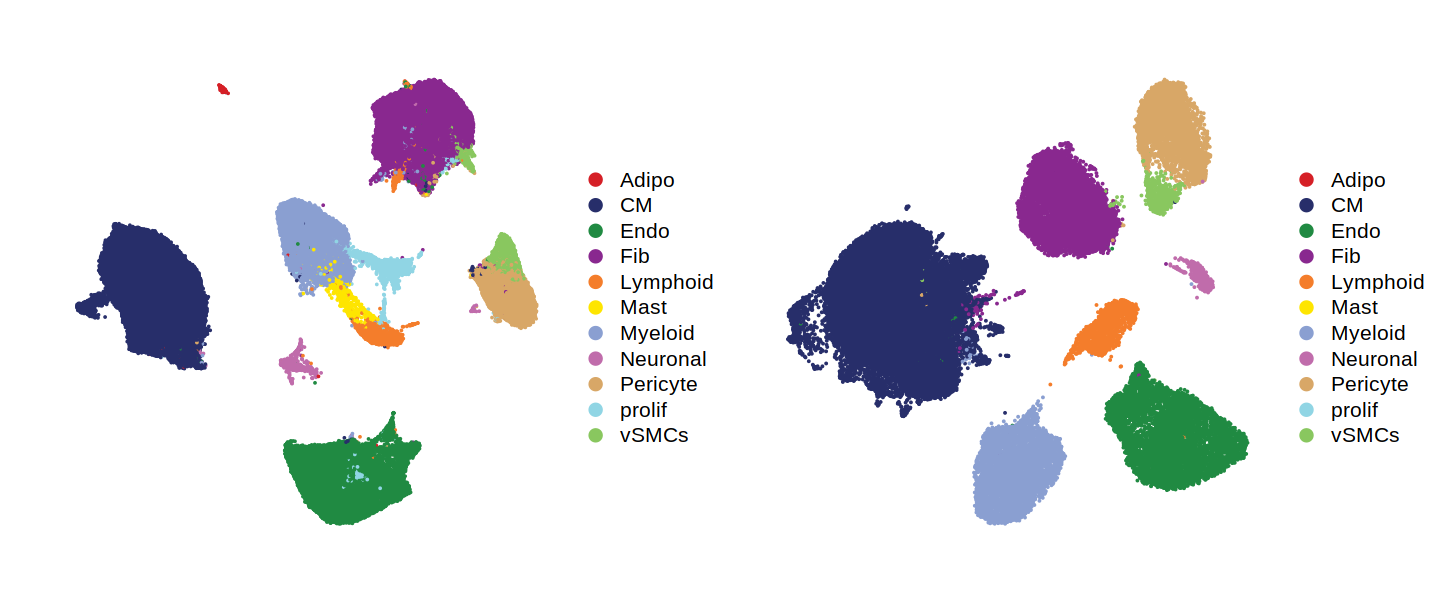

In [7]:
p1 <- DimPlot(obj.rna, reduction = "umap_harmony", group.by = "cell_type",
             raster = FALSE, size = 0.1) +
    scale_color_manual(values = cols) +
    xlab("") + ylab("") +
    ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())
    
p2 <- DimPlot(obj.atac, reduction = "umap_harmony_v2", group.by = "cell_type",
             size = 0.1, raster = FALSE) +
    scale_color_manual(values = cols) +
    xlab("") + ylab("") +
    ggtitle("") +
    theme(axis.ticks = element_blank(),
         axis.text = element_blank(),
         axis.line = element_blank())

options(repr.plot.height = 5, repr.plot.width = 12)

p1 + p2

In [8]:
ggsave("snRNA-UMAP.pdf", plot = p1, height = 5, width = 6)
ggsave("snATAC-UMAP.pdf", plot = p2, height = 5, width = 6)

In [9]:
Idents(obj.rna) <- "cell_type"

png 
  2

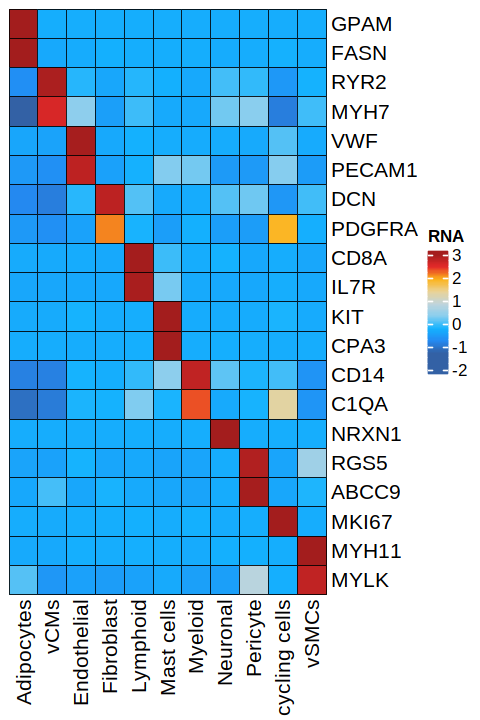

In [10]:
avg_rna <- AverageExpression(obj.rna, features = c(
    "GPAM", "FASN", # adipocytes
     "RYR2", "MYH7", # vCMs
    "VWF", "PECAM1", # Endo
    "DCN", "PDGFRA", # Fib
    "CD8A", "IL7R", # Lymphoid
    "KIT", "CPA3", # Mast cells
    "CD14", "C1QA", # Myeloid
    "NRXN1", # Neuronal 
    "RGS5", "ABCC9", # Pericyte
    "MKI67", # cycling
    "MYH11", "MYLK" # vSMCs
    ))$RNA

avg_rna_scale <- t(scale(t(avg_rna)))

avg_rna_scale <- avg_rna_scale[, c("Adipo", "CM", "Endo", "Fib", "Lymphoid" , "Mast", "Myeloid",
                                  "Neuronal", "Pericyte", "prolif", "vSMCs")]

colnames(avg_rna_scale) <- c("Adipocytes", "vCMs", "Endothelial", "Fibroblast", "Lymphoid", "Mast cells",
                            "Myeloid", "Neuronal", "Pericyte", "cycling cells", "vSMCs")

ht <- Heatmap(as.matrix(avg_rna_scale),
              rect_gp = gpar(col = "black", lwd = 0.5),
             col = ArchR::paletteContinuous("solarExtra", n = 100),
             cluster_rows = FALSE,
             cluster_columns = FALSE,
             name = "RNA")

options(repr.plot.height = 6, repr.plot.width = 4)

ht

pdf("RNA_markers.pdf", height = 6, width = 4)
draw(ht)
dev.off()

In [11]:
obj.atac <- readRDS("../../../snATAC/IntegrationWithsnRNA/data/snATAC.Rds")
obj.atac

An object of class Seurat 
560350 features across 46086 samples within 3 assays 
Active assay: RNA (19204 features, 0 variable features)
 2 other assays present: peaks, GeneActivity
 6 dimensional reductions calculated: scopen, umap, harmony, umap_harmony, umap_harmony_v2, pca

In [12]:
DefaultAssay(obj.atac) <- "GeneActivity"
Idents(obj.atac) <- "cell_type"

In [13]:
avg_chromatin_accessibility <- AverageExpression(obj.atac, assays = "GeneActivity", features = c(
     "RYR2", "MYH7", "TTN", # vCMs
    "VWF", "PECAM1", # Endo
    "DCN", "PDGFRA", # Fib
    "CD8A", "IL7R", # Lymphoid
    "CD14", "C1QA", # Myeloid
    "NRXN1", "NRXN3", # Neuronal 
    "RGS5", "ABCC9", # Pericyte
    "MYH11", "MYLK" # vSMCs
    ))$GeneActivity

avg_chromatin_accessibility_scale <- t(scale(t(avg_chromatin_accessibility)))

avg_chromatin_accessibility_scale <- avg_chromatin_accessibility_scale[, c("CM", "Endo", "Fib", "Lymphoid", 
                                                                           "Myeloid", "Neuronal", "Pericyte", "vSMCs")]

colnames(avg_chromatin_accessibility_scale) <- c("vCMs", "Endothelial", "Fibroblast", "Lymphoid",
                            "Myeloid", "Neuronal", "Pericyte", "vSMCs")

ht <- Heatmap(as.matrix(avg_chromatin_accessibility_scale),
              rect_gp = gpar(col = "black", lwd = 0.5),
             col = ArchR::paletteContinuous("blueYellow", n = 100),
             cluster_rows = FALSE,
             cluster_columns = FALSE,
             name = "ATAC")

options(repr.plot.height = 6, repr.plot.width = 4)

ht

pdf("ATAC_markers.pdf", height = 6, width = 4)
draw(ht)
dev.off()

ERROR: Error in vapply(X = keyed.objects, FUN = function(x) {: values must be length 1,
 but FUN(X[[1]]) result is length 0
